# Testing regressors

Which of the regressors will be the best to encode a face? Let's find out!

This notebook prexents a very naive approach, i.e. we will measure how good a regressor is by the MSE on a game face. The problem is the regressors will be used for real faces, which may casuse the regressor to not be able to infer any meaningful results if overfitted. 


My plan:
1. Get the datasets `X_faces`, `X_z` and `Y` from the training set.
2. Get regressors: M_LR, M_OMP, M_RF, M_MLP with default values (at least for now)
3. Train the regressors on `X_faces[:1000]` and `Y[:1000]`
4. Test the regressors on `X_faces[1000:]` and `Y[1000:]` 
5. Train the regressors on `X_z[:5000]` and `Y[:5000]`
6. Test the regressors on `X_z[5000:]` and `Y[5000:]`
7. Compare the results by creating a table with MSE, R2, and time of training and testing.


TODO:
 1. e2e tests
 2. cross-validation for finding best parameters of the best regressors

## 1. Preparation

In [13]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pickle

from time import time
from tqdm import tqdm

from sklearn.linear_model import LinearRegression, OrthogonalMatchingPursuit
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from pathlib import Path
import json

from find_z import load_generator
import torch

In [4]:
def load_and_concatenate(folder_path):
    file_paths = glob.glob(folder_path + '/*.npy')
    arrays = [np.load(file_path) for file_path in file_paths]
    concatenated_array = np.concatenate(arrays)
    return concatenated_array


def load_data():
    permute = np.load("permuted_100000.npy")
    
    X_faces = np.load("/media/pawel/DATA/tmp/freddie_mercuries/naive_input.npy")[permute]
    X_z = load_and_concatenate("/media/pawel/DATA/tmp/freddie_mercuries/en_face/new_vectors")
    Y = np.load("./data/outvec.npy")[permute]
    
    return X_faces, X_z, Y


X_faces, X_z, Y = load_data()
print(X_faces.shape, X_z.shape, Y.shape)

(100000, 65536) (11600, 256) (100000, 5)


In [5]:
def get_regressors():
    regressors = [
        # LinearRegression(),
        # OrthogonalMatchingPursuit(),
        # RandomForestRegressor(),
        MLPRegressor(hidden_layer_sizes=(128, 64, 32), max_iter=400, alpha=0.1, verbose=True)
    ]
    return regressors

regressors = get_regressors()

## Does it has sense?

Using 5 samples from X_faces, X_z and Y to determine if it is even close to each other.

In [10]:
sample_indexes = np.sort(np.random.randint(low=0, high=1000, size=(5,)))

sample_indexes

array([118, 336, 579, 587, 853])

In [12]:
generator = load_generator()

X_faces_sample, X_z_sample, Y_sample = X_faces[sample_indexes].reshape((5, 256, 256)), X_z[sample_indexes], Y[sample_indexes]
print(X_faces_sample.shape, X_z_sample.shape, Y_sample.shape)

(5, 256, 256) (5, 256) (5, 5)


In [15]:
def prep_tensor_to_show(tensor):
    return tensor.permute(1, 2, 0).detach().to('cpu').numpy()


def plot_images(images, labels, nrows, ncols, step=1, title="", figsize=[8, 4]):
    """Plot nrows x ncols images from images and set labels as titles."""
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        idx = i * step
        if images[i].shape[-1] == 1:
            ax.imshow((images[i]).reshape(images[idx].shape[0], images[idx].shape[1]))
        else:
            ax.imshow((images[idx]))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(labels[idx])
    fig.suptitle(title)
    plt.tight_layout()
    # plt.savefig(f"{title}.png")
    plt.show()
    
def z_to_image(z):
    z_tensor = torch.from_numpy(z).unsqueeze(0).cuda(0)
    return prep_tensor_to_show(generator(z_tensor)[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


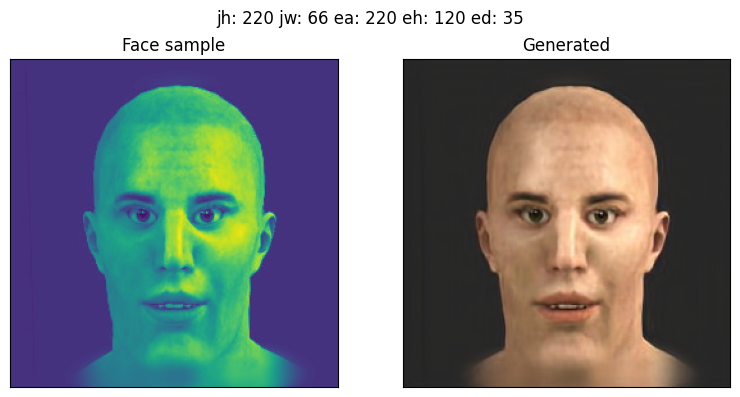

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


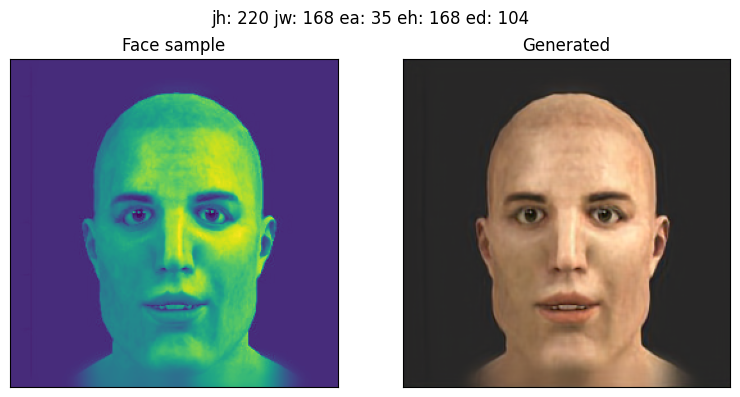

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


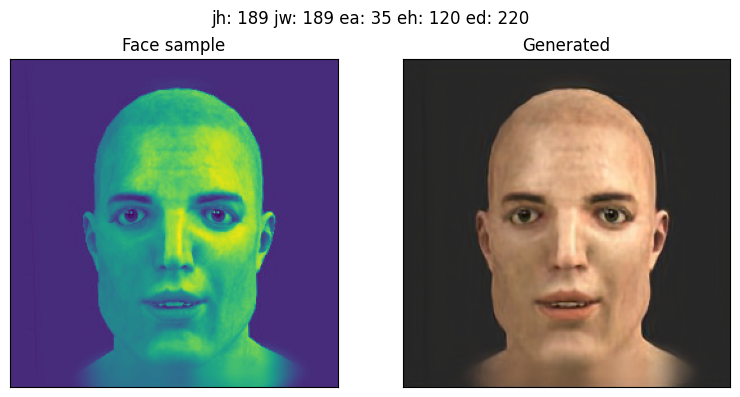

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


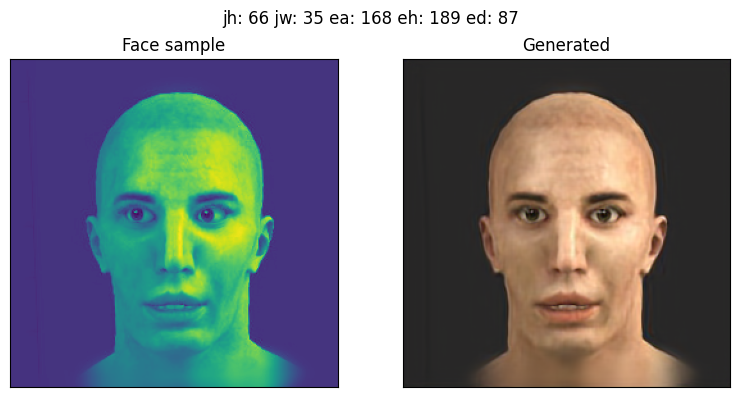

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


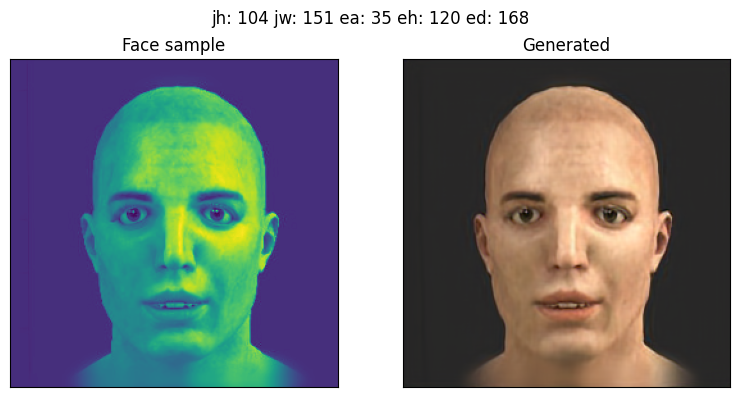

In [20]:
parameter_names = ["ed", "eh", "ea", "jw", "jh"][::-1]
param_title = lambda y: " ".join([f"{name}: {y_i}" for name, y_i in zip(parameter_names, y)])

for face_sample, z_sample, y_sample in zip(X_faces_sample, X_z_sample, Y_sample):
    plot_images([face_sample, z_to_image(z_sample)], ["Face sample", "Generated"], 1, 2, 1, param_title(y_sample))

## 2. Training



In [9]:
def save_model(model, path):
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    with open(path, 'wb') as f:
        pickle.dump(model, f)
    
def save_models(models, path):
    for name, model in models.items():
        save_model(model['model'], path + name + ".pickle")
        
def save_results(results: dict, path):
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    with open(path, 'w') as f:
        json.dump(results, f, default=lambda o: '<not serializable>')

In [10]:
def train_and_validate(X, Y, regressors, X_test=None, Y_test=None):
    X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    normalizer = Normalizer()
    X_train = normalizer.fit_transform(X_train)
    X_valid = normalizer.transform(X_valid)
    X_test = normalizer.transform(X_test) if X_test is not None else None
    save_model(normalizer, "normalizer.pickle")
    
    models = { f"{regressor.__class__.__name__}_{i}": {
        "scores": {
            "train": {},
            "valid": {},
            "test": {}
            }
        }      for i, regressor in enumerate(regressors) }
    
    for i, regressor in enumerate(regressors):
        name = f"{regressor.__class__.__name__}_{i}"
        print(f"Model: {name}")
        
        print(f"Training ...")
        t1 = time()
        regressor.fit(X_train, Y_train)
        models[name]["scores"]["train"]["time"] = time() - t1
        models[name]["model"] = regressor
        models[name]["scores"]["train"]["mse"] = mean_squared_error(Y_train, regressor.predict(X_train))
        models[name]["scores"]["train"]["r2"] = regressor.score(X_train, Y_train)
        
        print("Testing...")
        Y_pred = regressor.predict(X_valid)
        models[name]["scores"]['valid']["mse"] = mean_squared_error(Y_valid, Y_pred)
        models[name]["scores"]['valid']["r2"] = regressor.score(X_valid, Y_valid)

        print(f"MSE   train: {models[name]['scores']['train']['mse']:6f}   validation: {models[name]['scores']['valid']['mse']:6f}")
        print(f"R2    train: {models[name]['scores']['train']['r2']:6f}   validation: {models[name]['scores']['valid']['r2']:6f}")
        print(f"Training {name} took {models[name]['scores']['train']['time']:4f} s")
        
        if X_test is not None and Y_test is not None:
            print(f"Testing on provided data...")
            Y_pred = regressor.predict(X_test)
            models[name]["scores"]["test"]["mse"] = mean_squared_error(Y_test, Y_pred)
            models[name]["scores"]["test"]["r2"] = regressor.score(X_test, Y_test)
            print(f"MSE   test: {models[name]['scores']['test']['mse']:6f}")
            print(f"R2    test: {models[name]['scores']['test']['r2']:6f}")
        print("-----------------------")
        
    return models


### Faces

In [11]:
FACES_TEST_SIZE = 1000

X_face_train, X_face_test, Y_face_train, Y_face_test = X_faces[:FACES_TEST_SIZE], X_faces[FACES_TEST_SIZE:], Y[:FACES_TEST_SIZE], Y[FACES_TEST_SIZE:]
face_models = train_and_validate(X_face_train, Y_face_train, regressors, X_test=X_face_test[:1000], Y_test=Y_face_test[:1000])


Model: MLPRegressor_0
Training ...
Iteration 1, loss = 9644.69533181
Iteration 2, loss = 9572.03367847
Iteration 3, loss = 9463.76584184
Iteration 4, loss = 9299.48036068


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Testing...
MSE   train: 18041.205635   validation: 17787.275448
R2    train: -5.206300   validation: -5.120522
Training MLPRegressor_0 took 8.749717 s
Testing on provided data...
MSE   test: 17808.284763
R2    test: -5.084066
-----------------------


### Z

In [14]:
Z_TRAIN_SIZE = 11000
Z_TOTAL_SIZE = X_z.shape[0]

X_z_test, X_z_train, Y_z_test, Y_z_train = X_z[:Z_TRAIN_SIZE], X_z[Z_TRAIN_SIZE:], Y[:Z_TRAIN_SIZE], Y[Z_TRAIN_SIZE:Z_TOTAL_SIZE]
z_models = train_and_validate(X_z_train, Y_z_train, regressors, X_test=X_z_test, Y_test=Y_z_test)
# print("---------------------------")
# z_models_inverted = train_and_validate(X_z_test, Y_z_test, regressors, X_test=X_z_train, Y_test=Y_z_train)

Model: MLPRegressor_0
Training ...
Iteration 1, loss = 9622.14717589


Iteration 2, loss = 9613.31542408
Iteration 3, loss = 9605.34311457
Iteration 4, loss = 9597.35928477
Iteration 5, loss = 9588.63348957
Iteration 6, loss = 9579.10892435
Iteration 7, loss = 9568.83714320
Iteration 8, loss = 9557.62847920
Iteration 9, loss = 9544.79718382
Iteration 10, loss = 9529.48313434
Iteration 11, loss = 9510.83358579
Iteration 12, loss = 9488.13623405
Iteration 13, loss = 9460.28292609
Iteration 14, loss = 9425.72478259
Iteration 15, loss = 9383.79563154
Iteration 16, loss = 9332.26003266
Iteration 17, loss = 9269.61310581
Iteration 18, loss = 9193.20116730
Iteration 19, loss = 9101.20966928
Iteration 20, loss = 8990.40242116
Iteration 21, loss = 8858.67909574
Iteration 22, loss = 8701.89960008
Iteration 23, loss = 8519.57315710
Iteration 24, loss = 8303.29941235
Iteration 25, loss = 8055.45529162
Iteration 26, loss = 7770.84166127
Iteration 27, loss = 7445.16449280
Iteration 28, loss = 7081.80876184
Iteration 29, loss = 6677.73628414
Iteration 30, loss = 6240.22

/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


In [15]:
save_models(face_models, "./model/encoder/faces/")
save_models(z_models, "./model/encoder/z/")

save_results(face_models, "./results/encoder/faces.json")
save_results(z_models, "./results/encoder/z.json")

## Multiple training sizes

In [32]:
X_test, Y_test = X_face_test[:1000], Y_face_test[:1000]
for size in [200, 400, 600, 800, 1000]:
    X_face_train, Y_face_train = X_faces[:size], Y[:size]
    models = train_and_validate(X_face_train, Y_face_train, regressors, X_test=X_test, Y_test=Y_test)
    save_models(models, f"./model/encoder/faces/{size}/")
    save_results(models, f"./results/encoder/faces/{size}.json")

Model: LinearRegression_0
Training ...
Testing...
MSE   train: 0.000000   validation: 111.767472
R2    train: 1.000000   validation: 0.960090
Training LinearRegression_0 took 2.140913 s
Testing on provided data...
MSE   test: 185.409001
R2    test: 0.936274
-----------------------
Model: OrthogonalMatchingPursuit_1
Training ...


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/linear_model/_omp.py:435: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(


Testing...
MSE   train: 0.000000   validation: 409.078028
R2    train: 1.000000   validation: 0.858887
Training OrthogonalMatchingPursuit_1 took 3.541085 s
Testing on provided data...
MSE   test: 575.640438
R2    test: 0.802760
-----------------------
Model: RandomForestRegressor_2
Training ...
Testing...
MSE   train: 145.602667   validation: 1068.467636
R2    train: 0.949963   validation: 0.628550
Training RandomForestRegressor_2 took 341.699455 s
Testing on provided data...
MSE   test: 1089.594641
R2    test: 0.629405
-----------------------
Model: MLPRegressor_3
Training ...


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Testing...
MSE   train: 2925.206918   validation: 2803.780903
R2    train: 0.002917   validation: -0.013191
Training MLPRegressor_3 took 53.924958 s
Testing on provided data...
MSE   test: 2955.810787
R2    test: -0.009509
-----------------------
Model: LinearRegression_0
Training ...
Testing...
MSE   train: 0.000000   validation: 110.456961
R2    train: 1.000000   validation: 0.957949
Training LinearRegression_0 took 3.104435 s
Testing on provided data...
MSE   test: 169.894867
R2    test: 0.941291
-----------------------
Model: OrthogonalMatchingPursuit_1
Training ...


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/linear_model/_omp.py:435: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(


Testing...
MSE   train: 0.000000   validation: 361.968424
R2    train: 1.000000   validation: 0.863131
Training OrthogonalMatchingPursuit_1 took 11.235568 s
Testing on provided data...
MSE   test: 471.822334
R2    test: 0.837427
-----------------------
Model: RandomForestRegressor_2
Training ...
Testing...
MSE   train: 113.089668   validation: 683.237229
R2    train: 0.961652   validation: 0.742935
Training RandomForestRegressor_2 took 788.892968 s
Testing on provided data...
MSE   test: 786.321014
R2    test: 0.732080
-----------------------
Model: MLPRegressor_3
Training ...


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Testing...
MSE   train: 2872.799481   validation: 2691.767527
R2    train: 0.019798   validation: 0.003456
Training MLPRegressor_3 took 106.487666 s
Testing on provided data...
MSE   test: 2896.932590
R2    test: 0.010824
-----------------------
Model: LinearRegression_0
Training ...
Testing...
MSE   train: 0.000000   validation: 198.920919
R2    train: 1.000000   validation: 0.924650
Training LinearRegression_0 took 4.396966 s
Testing on provided data...
MSE   test: 175.315479
R2    test: 0.939365
-----------------------
Model: OrthogonalMatchingPursuit_1
Training ...


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/linear_model/_omp.py:435: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(


Testing...
MSE   train: 0.000000   validation: 423.024321
R2    train: 1.000000   validation: 0.840821
Training OrthogonalMatchingPursuit_1 took 24.024349 s
Testing on provided data...
MSE   test: 408.250173
R2    test: 0.859141
-----------------------
Model: RandomForestRegressor_2
Training ...
Testing...
MSE   train: 97.957678   validation: 721.833976
R2    train: 0.966455   validation: 0.752992
Training RandomForestRegressor_2 took 1293.282857 s
Testing on provided data...
MSE   test: 706.229402
R2    test: 0.759568
-----------------------
Model: MLPRegressor_3
Training ...


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Testing...
MSE   train: 2753.303223   validation: 2797.102404
R2    train: 0.058618   validation: 0.046863
Training MLPRegressor_3 took 160.360831 s
Testing on provided data...
MSE   test: 2779.306651
R2    test: 0.051785
-----------------------
Model: LinearRegression_0
Training ...
Testing...
MSE   train: 0.000000   validation: 136.878927
R2    train: 1.000000   validation: 0.954671
Training LinearRegression_0 took 6.238192 s
Testing on provided data...
MSE   test: 168.319100
R2    test: 0.941735
-----------------------
Model: OrthogonalMatchingPursuit_1
Training ...


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/linear_model/_omp.py:435: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(


Testing...
MSE   train: 0.000000   validation: 408.863276
R2    train: 1.000000   validation: 0.864372
Training OrthogonalMatchingPursuit_1 took 42.244902 s
Testing on provided data...
MSE   test: 430.542133
R2    test: 0.851081
-----------------------
Model: RandomForestRegressor_2
Training ...
Testing...
MSE   train: 86.239076   validation: 622.776339
R2    train: 0.969699   validation: 0.795297
Training RandomForestRegressor_2 took 1842.199831 s
Testing on provided data...
MSE   test: 641.915340
R2    test: 0.781336
-----------------------
Model: MLPRegressor_3
Training ...


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Testing...
MSE   train: 2627.792898   validation: 2820.169219
R2    train: 0.079164   validation: 0.069650
Training MLPRegressor_3 took 204.211432 s
Testing on provided data...
MSE   test: 2721.689778
R2    test: 0.071750
-----------------------
Model: LinearRegression_0
Training ...
Testing...
MSE   train: 0.000000   validation: 233.680800
R2    train: 1.000000   validation: 0.919810
Training LinearRegression_0 took 8.902577 s
Testing on provided data...
MSE   test: 185.205599
R2    test: 0.935869
-----------------------
Model: OrthogonalMatchingPursuit_1
Training ...


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/linear_model/_omp.py:435: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(


Testing...
MSE   train: 0.000000   validation: 473.329916
R2    train: 1.000000   validation: 0.836294
Training OrthogonalMatchingPursuit_1 took 71.313658 s
Testing on provided data...
MSE   test: 461.010905
R2    test: 0.840442
-----------------------
Model: RandomForestRegressor_2
Training ...
Testing...
MSE   train: 81.895646   validation: 601.311181
R2    train: 0.971823   validation: 0.792502
Training RandomForestRegressor_2 took 2386.853280 s
Testing on provided data...
MSE   test: 590.238341
R2    test: 0.798775
-----------------------
Model: MLPRegressor_3
Training ...


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Testing...
MSE   train: 2726.650465   validation: 2749.937654
R2    train: 0.062696   validation: 0.054062
Training MLPRegressor_3 took 224.050393 s
Testing on provided data...
MSE   test: 2768.647171
R2    test: 0.055365
-----------------------


#### Bonus! Trying different MLPs


In [9]:

mlp_regressors = [
    MLPRegressor(hidden_layer_sizes=(128),),
    MLPRegressor(hidden_layer_sizes=(128, 64)),
    MLPRegressor(hidden_layer_sizes=(128, 64, 32)),
    MLPRegressor(hidden_layer_sizes=(128, 64, 32, 16)),
    MLPRegressor(hidden_layer_sizes=(128, 64, 32, 16, 8))
]

In [10]:
z_mlp_models = train_and_validate(X_z_train, Y_z_train, mlp_regressors, X_test=X_z_test, Y_test=Y_z_test)

Model: MLPRegressor_0
Training ...


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Testing...
MSE   train: 2539.011192   validation: 2741.246231
R2    train: 0.135590   validation: 0.066152
Training MLPRegressor_0 took 5.325113 s
Testing on provided data...
MSE   test: 3335.869475
R2    test: -0.138676
-----------------------
Model: MLPRegressor_1
Training ...


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Testing...
MSE   train: 1157.302287   validation: 1432.364179
R2    train: 0.606627   validation: 0.510815
Training MLPRegressor_1 took 5.607697 s
Testing on provided data...
MSE   test: 3122.172330
R2    test: -0.065998
-----------------------
Model: MLPRegressor_2
Training ...


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Testing...
MSE   train: 274.749135   validation: 900.345717
R2    train: 0.907510   validation: 0.693055
Training MLPRegressor_2 took 6.074667 s
Testing on provided data...
MSE   test: 3839.409614
R2    test: -0.310408
-----------------------
Model: MLPRegressor_3
Training ...


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Testing...
MSE   train: 1304.634821   validation: 1595.601181
R2    train: 0.560326   validation: 0.455837
Training MLPRegressor_3 took 6.573971 s
Testing on provided data...
MSE   test: 3482.496787
R2    test: -0.188861
-----------------------
Model: MLPRegressor_4
Training ...
Testing...
MSE   train: 1777.571479   validation: 2169.653572
R2    train: 0.394365   validation: 0.262043
Training MLPRegressor_4 took 7.399696 s
Testing on provided data...
MSE   test: 3332.409264
R2    test: -0.137637
-----------------------


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [17]:
mlp_bigger_alpha_regressors = [
    MLPRegressor(hidden_layer_sizes=(128, 64, 32, 16, 8), alpha=0.001),
    MLPRegressor(hidden_layer_sizes=(128, 64, 32, 16, 8), alpha=0.01),
    MLPRegressor(hidden_layer_sizes=(128, 64, 32, 16, 8), alpha=0.1),
    MLPRegressor(hidden_layer_sizes=(128, 64, 32, 16, 8), alpha=1),
    MLPRegressor(hidden_layer_sizes=(128, 64, 32, 16, 8), alpha=10)
]
    


z_mlp_bigger_alpha_models = train_and_validate(X_z_train, Y_z_train, mlp_bigger_alpha_regressors, X_test=X_z_test, Y_test=Y_z_test)

Model: MLPRegressor_0
Training ...


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Testing...
MSE   train: 1621.199057   validation: 4370.266300
R2    train: 0.444777   validation: -0.480488
Training MLPRegressor_0 took 90.635764 s
Testing on provided data...
MSE   test: 3731.174181
R2    test: -0.264210
-----------------------
Model: MLPRegressor_1
Training ...


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Testing...
MSE   train: 1785.886481   validation: 4208.526610
R2    train: 0.388666   validation: -0.428263
Training MLPRegressor_1 took 67.593153 s
Testing on provided data...
MSE   test: 3873.832012
R2    test: -0.313193
-----------------------
Model: MLPRegressor_2
Training ...


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Testing...
MSE   train: 2380.988848   validation: 3299.848041
R2    train: 0.185796   validation: -0.118681
Training MLPRegressor_2 took 22.220021 s
Testing on provided data...
MSE   test: 3141.443045
R2    test: -0.064619
-----------------------
Model: MLPRegressor_3
Training ...


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Testing...
MSE   train: 1625.143582   validation: 4271.744768
R2    train: 0.444300   validation: -0.444201
Training MLPRegressor_3 took 59.662424 s
Testing on provided data...
MSE   test: 3687.583618
R2    test: -0.252403
-----------------------
Model: MLPRegressor_4
Training ...
Testing...
MSE   train: 1416.860344   validation: 4712.738722
R2    train: 0.515396   validation: -0.601942
Training MLPRegressor_4 took 85.440482 s
Testing on provided data...
MSE   test: 4214.834446
R2    test: -0.427988
-----------------------


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [21]:
mlp_different_iter_regressors = [
    MLPRegressor(hidden_layer_sizes=(128,64), max_iter=200),
    MLPRegressor(hidden_layer_sizes=(128,64), max_iter=400),
    MLPRegressor(hidden_layer_sizes=(128,64), max_iter=600),
    MLPRegressor(hidden_layer_sizes=(128,64), max_iter=800),
    MLPRegressor(hidden_layer_sizes=(128,64), max_iter=1000)
]

z_mlp_different_iter_models = train_and_validate(X_z_train, Y_z_train, mlp_different_iter_regressors, X_test=X_z_test, Y_test=Y_z_test)

Model: MLPRegressor_0
Training ...


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Testing...
MSE   train: 2075.482804   validation: 2999.711074
R2    train: 0.290986   validation: -0.021803
Training MLPRegressor_0 took 35.076074 s
Testing on provided data...
MSE   test: 1985.666946
R2    test: 0.328280
-----------------------
Model: MLPRegressor_1
Training ...


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Testing...
MSE   train: 1027.253332   validation: 4199.907813
R2    train: 0.649038   validation: -0.431527
Training MLPRegressor_1 took 85.974538 s
Testing on provided data...
MSE   test: 3112.836865
R2    test: -0.052942
-----------------------
Model: MLPRegressor_2
Training ...


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


Testing...
MSE   train: 500.527108   validation: 5576.276629
R2    train: 0.828962   validation: -0.899456
Training MLPRegressor_2 took 146.529135 s
Testing on provided data...
MSE   test: 4544.358006
R2    test: -0.538690
-----------------------
Model: MLPRegressor_3
Training ...


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(


Testing...
MSE   train: 361.038135   validation: 6368.318591
R2    train: 0.876629   validation: -1.170974
Training MLPRegressor_3 took 161.944777 s
Testing on provided data...
MSE   test: 5301.342213
R2    test: -0.792946
-----------------------
Model: MLPRegressor_4
Training ...


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Testing...
MSE   train: 256.883746   validation: 7017.877939
R2    train: 0.912254   validation: -1.391625
Training MLPRegressor_4 took 175.791965 s
Testing on provided data...
MSE   test: 5820.026468
R2    test: -0.969657
-----------------------


In [22]:
mlp_different_iter_regularizedregressors = [
    MLPRegressor(hidden_layer_sizes=(128,64), max_iter=1000, alpha=0.001),
    MLPRegressor(hidden_layer_sizes=(128,64), max_iter=1000, alpha=0.01),
    MLPRegressor(hidden_layer_sizes=(128,64), max_iter=1000, alpha=0.1),
    MLPRegressor(hidden_layer_sizes=(128,64), max_iter=1000, alpha=1),
    MLPRegressor(hidden_layer_sizes=(128,64), max_iter=1000, alpha=10),
]

z_mlp_different_iter_models = train_and_validate(X_z_train, Y_z_train, mlp_different_iter_regressors, X_test=X_z_test, Y_test=Y_z_test)

Model: MLPRegressor_0
Training ...


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Testing...
MSE   train: 2037.291320   validation: 3013.946276
R2    train: 0.306350   validation: -0.041283
Training MLPRegressor_0 took 61.948158 s
Testing on provided data...
MSE   test: 2008.732700
R2    test: 0.320692
-----------------------
Model: MLPRegressor_1
Training ...


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Testing...
MSE   train: 798.760349   validation: 4483.733755
R2    train: 0.727572   validation: -0.547799
Training MLPRegressor_1 took 126.711411 s
Testing on provided data...
MSE   test: 3641.647301
R2    test: -0.231930
-----------------------
Model: MLPRegressor_2
Training ...


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


Testing...
MSE   train: 458.158243   validation: 5616.300629
R2    train: 0.843788   validation: -0.939679
Training MLPRegressor_2 took 143.417865 s
Testing on provided data...
MSE   test: 4696.370524
R2    test: -0.589742
-----------------------
Model: MLPRegressor_3
Training ...


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(


Testing...
MSE   train: 361.631607   validation: 6427.622011
R2    train: 0.876739   validation: -1.220290
Training MLPRegressor_3 took 214.398274 s
Testing on provided data...
MSE   test: 5336.007526
R2    test: -0.806763
-----------------------
Model: MLPRegressor_4
Training ...


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Testing...
MSE   train: 239.871411   validation: 6696.317033
R2    train: 0.918254   validation: -1.313555
Training MLPRegressor_4 took 224.950246 s
Testing on provided data...
MSE   test: 5584.159705
R2    test: -0.890250
-----------------------
